# Design of spritz pipeline

## Introduction

In this notebook, we use the new 'lisa instrument' simulation tool to adjust spritz pipeline parameters, in particular the filters and time offsets needed to perform a 16Hz/4Hz simulation, as done in LISANode. 

We focus here on the simulation of the 17 verification binaries, over a week time scale. 

It can be used as a demonstration of how to use the different tools:
- glitch simulation
- GW simulation
- orbits computation
- noise simulation with lisa instrument
- TDI computation with pyTDI

In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import numpy as np
import os
import xarray as xr
import logging
from astropy import units as u
import pandas as pd
import h5py
import pdb
import ldc.io.hdf5 as h5io
from ldc.waveform.source import load_gb_catalog, load_mbhb_catalog
#from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain, to_file, from_file
#from ldc.common.series import TimeSeries, FrequencySeries
#import ldc.waveform.fastGB as fastGB
#from ldc.common.tools import compute_tdi_snr, window
from ldc.waveform.waveform import HpHc
from ldc.common import constants

from lisainstrument import Instrument
import pytdi
from pytdi.michelson import X2, Y2, Z2
from pytdi import Data
import lisaglitch 
import lisaorbits

/usr/lib/python3.9/typing.py:984: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## Define simulation parameters

In [2]:
dt = 5 # waveform sampling
t_max = 60*60*24*7 #365 # time of observation = 1yr
t_min = 0

## Orbits

In [3]:
dto = 86400
N = int(t_max/dto)+1
L = 2.5e9 # m
o = lisaorbits.EqualArmlengthOrbits(L=L, dt=dto, size=N, tt_order=1)
os.remove("orbits.h5"); 
o.write('orbits.h5')

#To be used in ldc
config = {'nominal_arm_length':L, "orbit_type":'file', 'filename':'orbits.h5'}
orbits = Orbits.type(config)

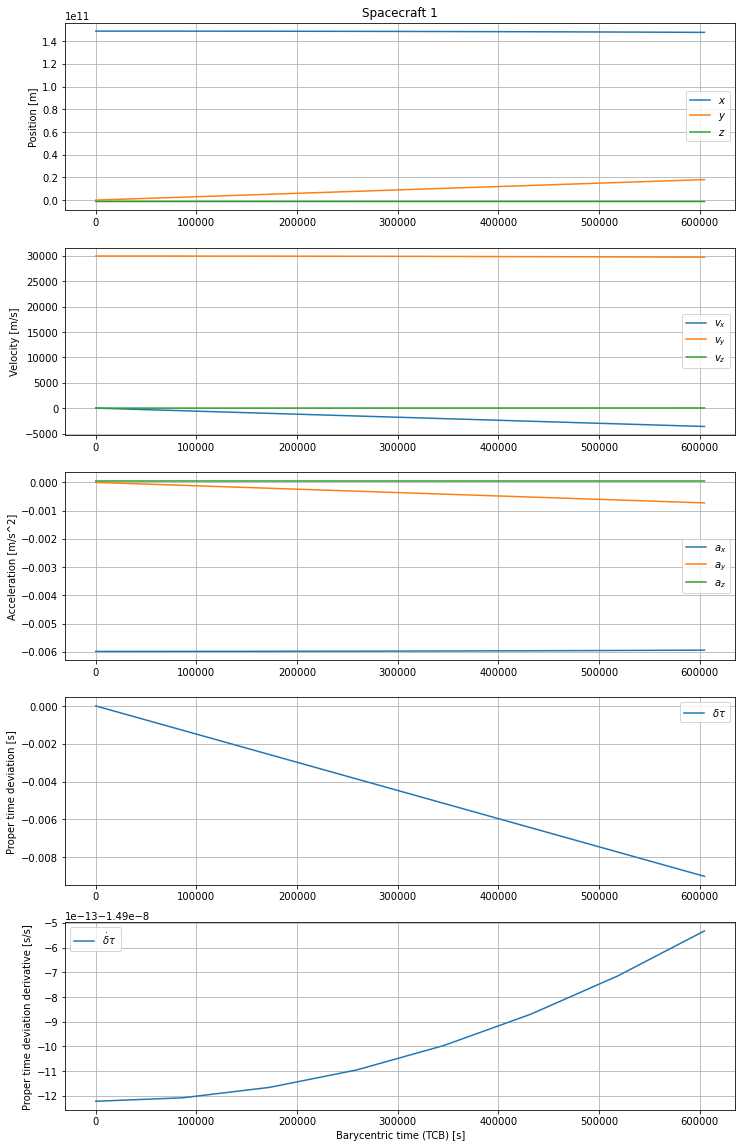

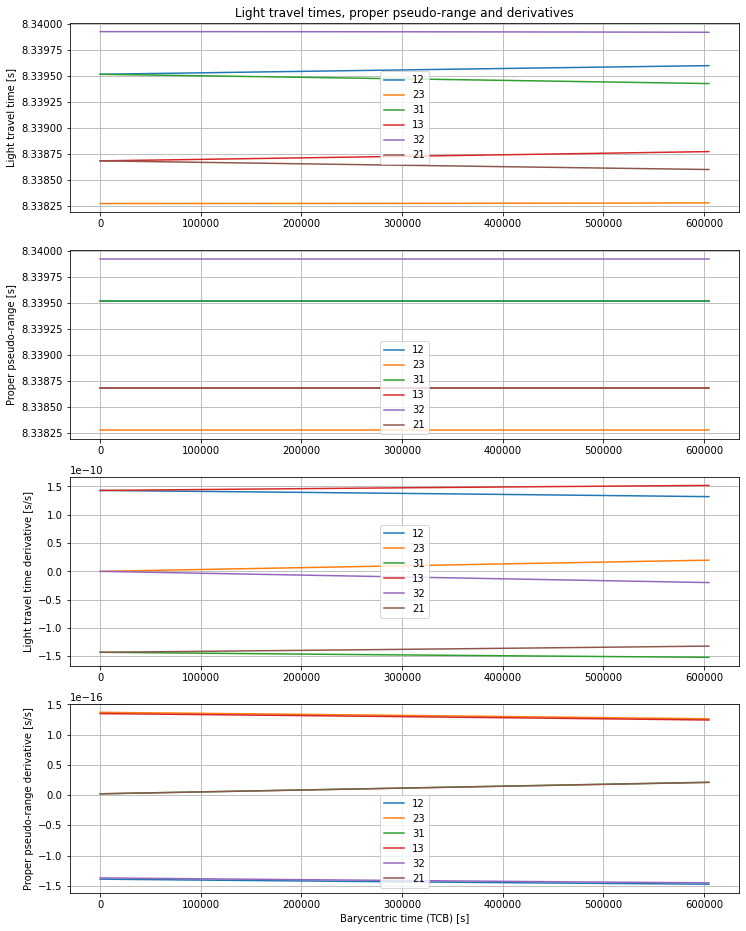

In [4]:
o.plot_spacecraft(1)
o.plot_links()

## Gravitational waves from VGB

In [5]:
cat, units = load_gb_catalog("../data/VGB.h5"); units.pop("Name")
Proj = ProjectedStrain(orbits)
GWs = HpHc.type("vgb", "GB", "TD_fdot")
GWs.set_param(cat, units=units); GWs = GWs.split()
yArm = Proj.arm_response(t_min, t_max, dt, GWs)
os.remove("strain.h5");
to_file("strain.h5", yArm, cat["Name"], Proj.links, t_min, t_max, dt)

2021-06-09 10:24:48,165 - lisa - INFO - Load hdf5 H5LISA catalog: ../data/VGB.h5 ...


(0.0, 10000.0, -1.0003510854947273e-22, 1.0363818160241211e-22)

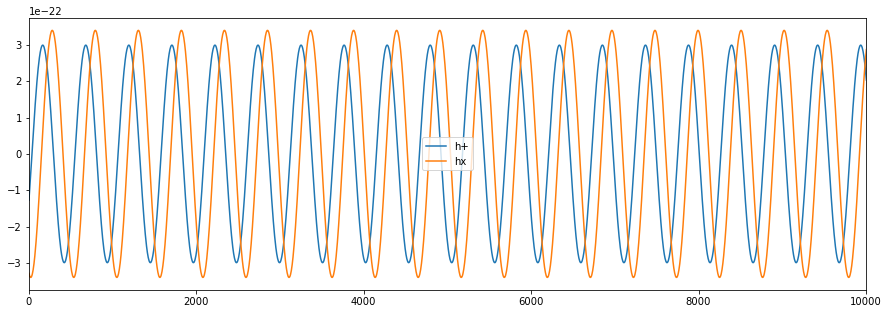

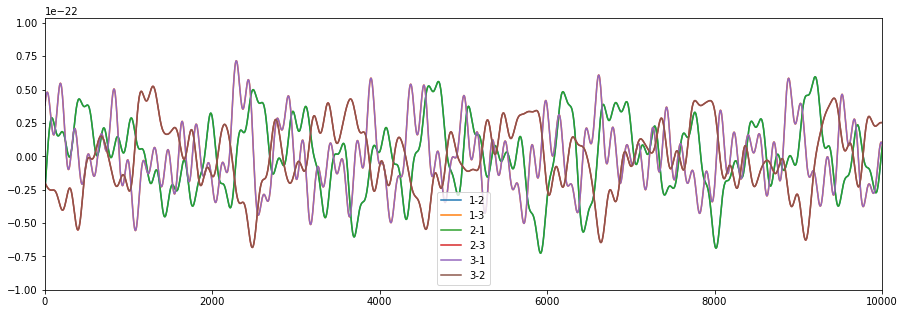

In [6]:
tvec = np.arange(t_min, t_max, dt)
hp, hc = GWs[0].compute_hphc_td(tvec)
plt.figure(figsize=(15,5))
plt.plot(tvec, hp, label="h+")
plt.plot(tvec, hc, label="hx")
plt.legend()
plt.axis([0,10000,None,None])

plt.figure(figsize=(15,5))
for i in range(6):
    plt.plot(tvec, yArm[:,i], label=Proj.links[i])
plt.legend()
plt.axis([0,10000,None,None])

## Glitch

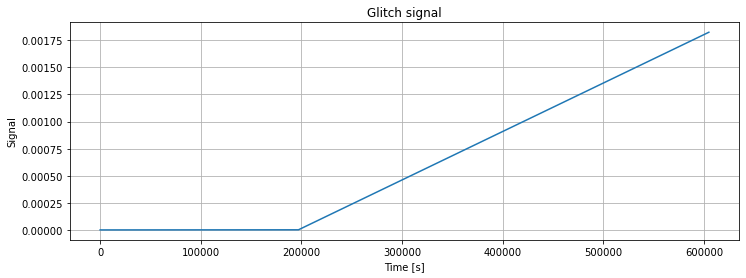

In [7]:
# List of the injection points to sample from
inj_points = ['tm_12', 'tm_23', 'tm_31', 'tm_13', 'tm_32', 'tm_21']
N = int(t_max/dt)
beta = 20
amp = 1e-6
t_inj = 196912
g = lisaglitch.ShapeletGlitch(inj_point=np.random.choice(inj_points),t0=t_min, size=N, dt=dt, 
                              t_inj=t_inj, beta=beta, amp=amp)           
os.remove("glitch.h5"); 
g.write('glitch.h5')
g.plot(tmin=t_min, tmax=t_max)

## TDI

In [8]:
logger = logging.getLogger('lisainstrument')
logger.setLevel(logging.INFO)

dt_instru = 1/4.
physics_upsampling = 4
dt_physic = dt_instru/physics_upsampling

yArm, snames, links, tmin, tmax, dt = from_file('strain.h5')

# write down the values of the straing + time vector
gw = {"t": np.arange(tmin, tmax+dt_physic, dt_physic)}
for j, n in enumerate(links):
    r,s = int(n[0]), int(n[-1])
    if dt != dt_physic:
        gw[f"{r}{s}"] = scipy.interpolate.InterpolatedUnivariateSpline(tvec, yArm[:,j], k=5)(gw["t"])
    else:
        gw[f"{r}{s}"] = yArm[:,j]
            
central_freq = 2.816E14
if physics_upsampling == 1:
    aafilter = None
else:
    aafilter = ('kaiser', 240, 1.1, 2.9)
    aafilter_deltat = 4.5 # sec
            
N = np.min([120960, int(tmax/dt_instru)]) #int(tmax/dt_instru)       
for k,v in gw.items():
        gw[k] = gw[k][0:N*physics_upsampling]
        
i = Instrument(physics_upsampling=physics_upsampling, aafilter=aafilter, size=N, dt=dt_instru,
               gws=gw, orbits="orbits.h5", central_freq=central_freq)

lasernoise = False #True
noisefree = True
if noisefree:
    if lasernoise:
        i.disable_all_noises(but='laser')
    else:
        i.disable_all_noises()
else:
    i.disable_clock_noises()
i.simulate()

data = Data.from_instrument(i)
data.delay_derivative = None
built = X2.build(**data.args_nodoppler)
X2_data = built(data.measurements)/central_freq

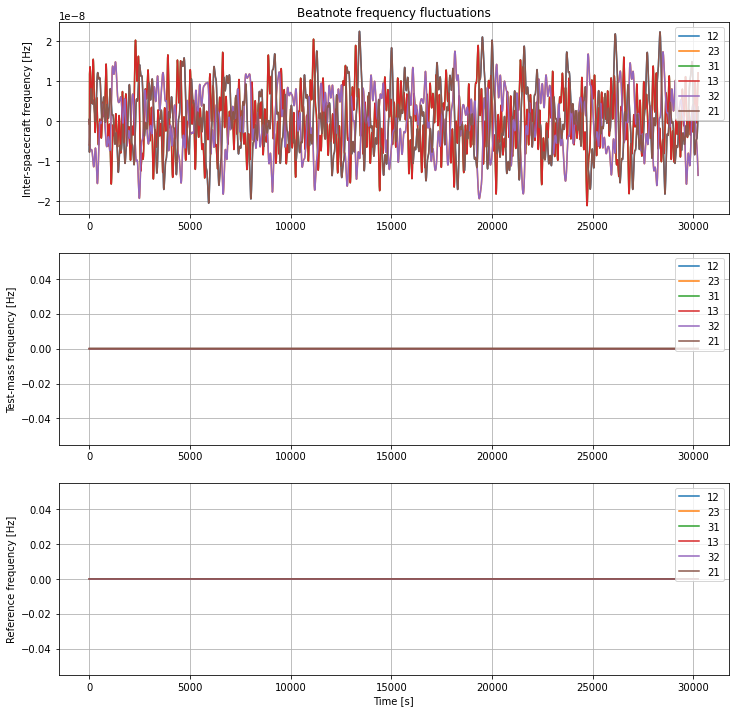

In [9]:
i.plot_fluctuations()

In [10]:
def kaiser_filtering(data, dt_i, attenuation=240, freq1=0.05, freq2=0.1, delay=161.75):
    """ Apply Kaiser filtering
    """
    df = 1/dt_i
    numtaps, beta = signal.kaiserord(attenuation, (freq2 - freq1) / (df/2.))
    filter_coeff = signal.firwin(numtaps, 0.1, window=('kaiser', beta))
    return signal.lfilter(filter_coeff, 1, data), delay

## Apply delays and filters
time_delay = 0
if aafilter is not None: # time shift of aafilter
    time_delay += aafilter_deltat
    X2_data_fl = X2_data
if lasernoise or not noisefree:
    X2_data_fl, delay = kaiser_filtering(X2_data, dt_instru)
    time_delay += delay

## Downsampling
tvec = np.arange(tmin, tmax, dt)
X2_data_ds = scipy.interpolate.InterpolatedUnivariateSpline(i.t-time_delay, X2_data_fl, k=5)(tvec)
        

## Compare TDI outputs

(3000.0, 5000.0, -2e-28, 2e-28)

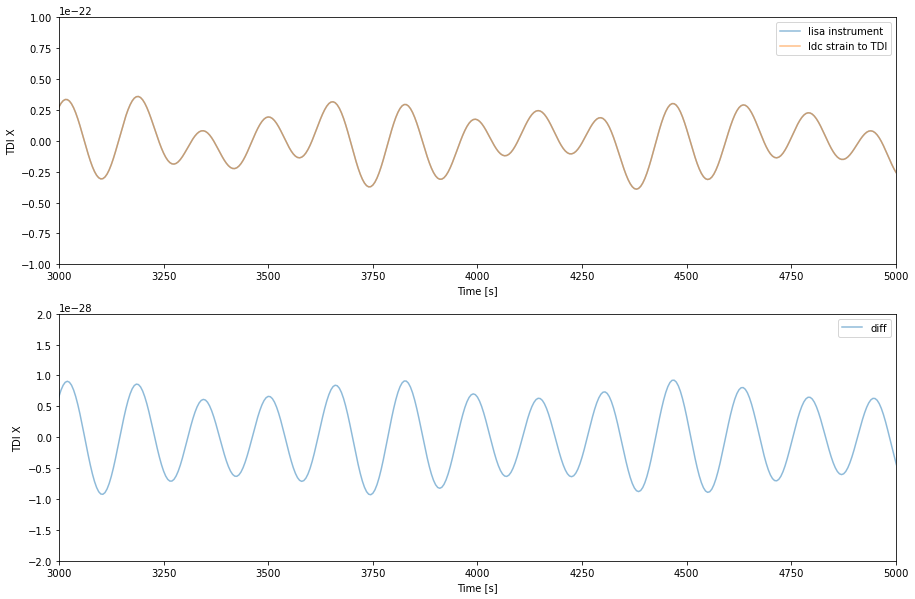

In [11]:
tdi_x = Proj.compute_tdi_x(tvec, tdi2=True)

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.subplot(211)
#plt.axvline(x=196912.03946846604, alpha=0.5, color='k')
plt.plot(tvec, X2_data_ds, label="lisa instrument", alpha=0.5)
plt.plot(tvec, tdi_x, label="ldc strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([3000, 5000, -1e-22, 1e-22])

plt.subplot(212)
plt.axvline(x=t_inj, alpha=0.5, color='k')
plt.plot(tvec, X2_data_ds-tdi_x, label="diff", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([3000, 5000, -2e-28, 2e-28])#198000, None, None])


Difference between expected TDI and TDI obtained through lisa instrument without resampling and without laser noise is around 0.05%

## Including resampling

In [13]:
dt_i = 1/4. # 4Hz - 16Hz is the baseline
N = int(t_max/dt)
dt_p = dt_i/4.
yArm = Proj.arm_response(t_min, N*dt_p, dt_p, GWs)

gw = {"t": np.arange(t_min, N*(dt_i/4), dt_i/4)}  
for j, n in enumerate(Proj.links):
    s,r = int(n[0]), int(n[-1])
    gw[f"{s}{r}"] = yArm[:,j]

i2 = Instrument(physics_upsampling=4, size=N/4, dt=dt_i, orbits="orbits.h5", gws=gw) 
i2.disable_all_noises()#but='laser')
i2.simulate()

data = Data.from_instrument(i2)
data.delay_derivative = None
built = X2.build(**data.args_nodoppler)
X2_data_rs = built(data.measurements)/central_freq

(1000.0, 1500.0, -1e-30, 1e-30)

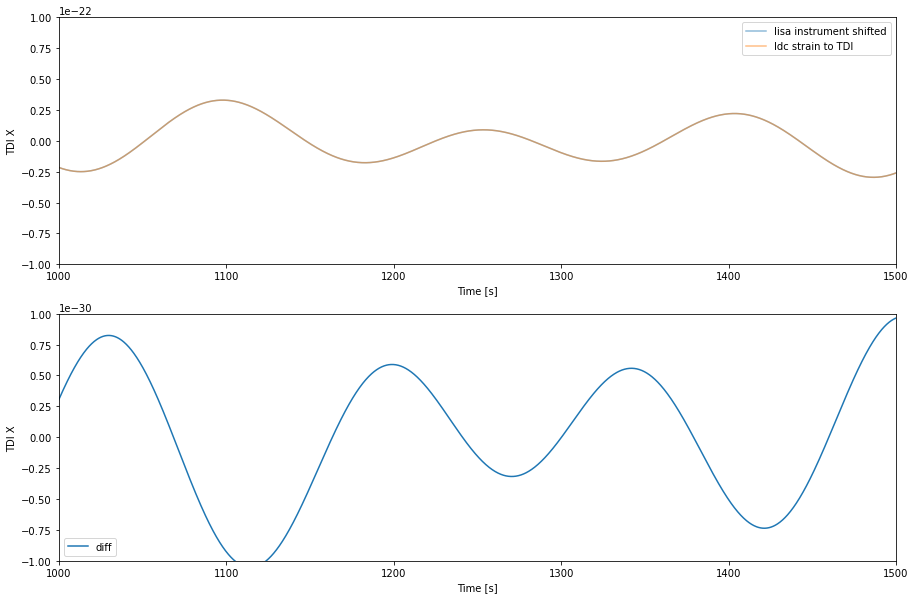

In [16]:
aafilter_deltat = 4.5 # sec
i0 = int(aafilter_deltat/dt_i)
X2_data_shifted = np.zeros((len(X2_data_rs)))
X2_data_shifted[:-i0] = X2_data_rs[i0:]
tdi_x = Proj.compute_tdi_x(i2.t, tdi2=True)

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.subplot(211)
plt.plot(i2.t, X2_data_shifted, label="lisa instrument shifted", alpha=0.5)
plt.plot(i2.t, tdi_x, label="ldc strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([1000, 1500, -1e-22, 1e-22])
plt.subplot(212)
plt.plot(i2.t, (X2_data_shifted-tdi_x[0:len(i2.t)]), label="diff", alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([1000, 1500, -1e-30, 1e-30])#198000, None, None])


Difference between expected TDI and TDI obtained through lisa instrument with resampling and without laser noise is near to numerical precision (including a time shift of 4.5s)

## Downsampling lisa instrument output to original dt

/usr/lib/python3/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 65536 is greater than input length  = 1512, using nperseg = 1512
  warnings.warn('nperseg = {0:d} is greater than input length '


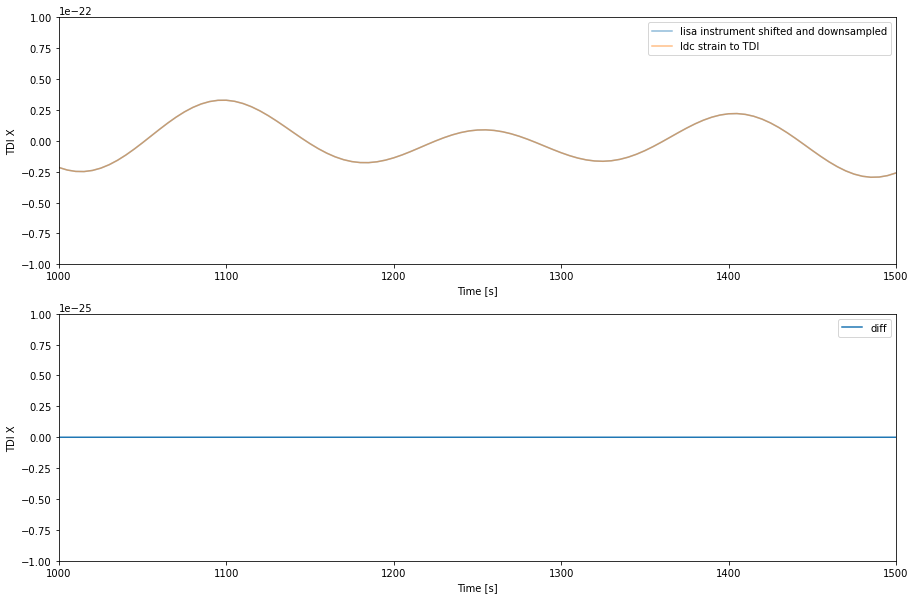

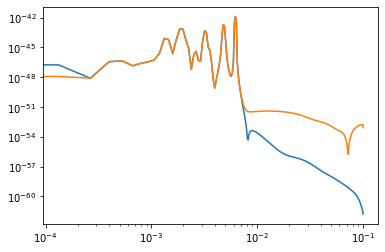

In [17]:
r_dt = int(dt/dt_i)
X2_data_ds = X2_data_shifted[::r_dt]
tvec = i2.t[::r_dt]

tdi_x = Proj.compute_tdi_x(tvec, tdi2=True)

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.subplot(211)
plt.plot(tvec, X2_data_ds, label="lisa instrument shifted and downsampled", alpha=0.5)
plt.plot(tvec, tdi_x, label="ldc strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([1000, 1500, -1e-22, 1e-22])
plt.subplot(212)
plt.plot(tvec, (X2_data_ds-tdi_x), label="diff", alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([1000, 1500, -1e-25, 1e-25])#198000, None, None])

f, psd_gw = scipy.signal.welch(tdi_x, fs=1.0/dt, window='hanning', nperseg=256*256)
f, psd_x = scipy.signal.welch(X2_data_ds, fs=1.0/dt, window='hanning', nperseg=256*256)
plt.figure()
plt.loglog(f, psd_gw)
plt.loglog(f, psd_x)

## Including laser noise

In [18]:
yArm = Proj.arm_response(t_min, N*dt, dt, GWs)

gw = {"t": np.arange(t_min, N*dt, dt)}  
for j, n in enumerate(Proj.links):
    s,r = int(n[0]), int(n[-1])
    gw[f"{s}{r}"] = yArm[:,j]

#i3 = Instrument(physics_upsampling=4, size=N, dt=dt, orbits="orbits.h5", gws=gw, aafilter=None) 
i2.disable_all_noises(but='laser')
i2.simulate()

data = Data.from_instrument(i2)
data.delay_derivative = None
built = X2.build(**data.args_nodoppler)
X2_data_laser = built(data.measurements)/central_freq

We need to filter again the TDI output to remove aliasing due to downsampling of high freq noise. 

/usr/lib/python3/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 65536 is greater than input length  = 30240, using nperseg = 30240
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/lib/python3/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 65536 is greater than input length  = 1512, using nperseg = 1512
  warnings.warn('nperseg = {0:d} is greater than input length '


(5000.0, 7000.0, -2e-25, 2e-25)

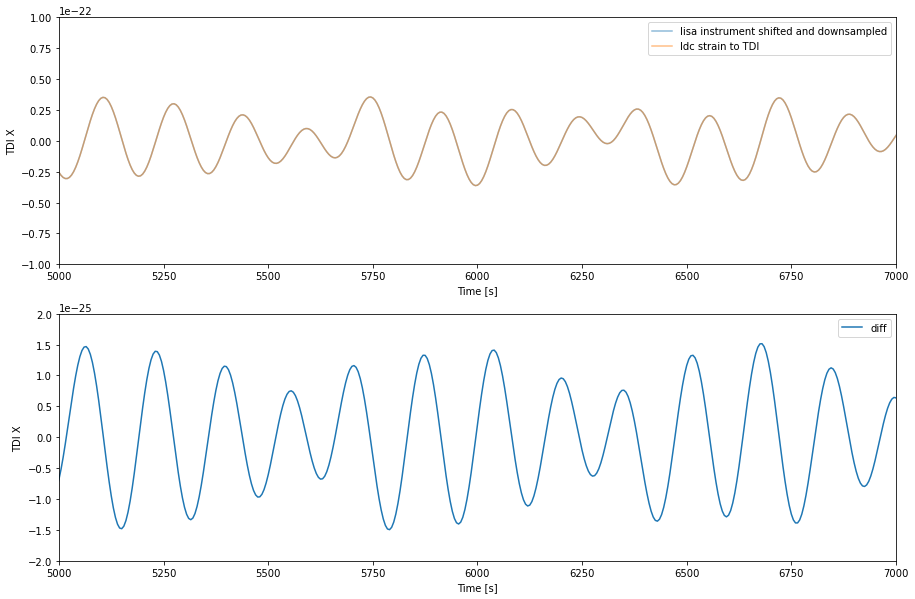

In [19]:
aafilter_deltat = 4.5 # sec
i0 = int(aafilter_deltat/dt_i)
X2_data_shifted = np.zeros((len(X2_data_laser)))
X2_data_shifted[:-i0] = X2_data_laser[i0:]
X2_data_ds = X2_data_shifted[::r_dt]
tvec = i2.t[::r_dt]

attenuation = 240
freq1 = 0.1
freq2 = 0.2
df = 1/dt_i
numtaps, beta = scipy.signal.kaiserord(attenuation, (freq2 - freq1) / (df/2.))
filter_coeff = scipy.signal.firwin(numtaps, 0.1, window=('kaiser', beta))
X2_data_filtered = scipy.signal.lfilter(filter_coeff, 1, X2_data_shifted)

f0, psd_0 = scipy.signal.welch(X2_data_laser, fs=1.0/dt_i, window='hanning', nperseg=256*256)
f1, psd_1 = scipy.signal.welch(X2_data_filtered, fs=1.0/dt_i, window='hanning', nperseg=256*256)

tdifilter_deltat = 81 # sec
i1 = int(tdifilter_deltat/dt_i)
X2_data_filtered_shifted = np.zeros((len(X2_data_filtered)))
X2_data_filtered_shifted[:-i1] = X2_data_filtered[i1:]

X2_data_filtered_shifted = X2_data_filtered_shifted[::r_dt]
f2, psd_2 = scipy.signal.welch(X2_data_filtered_shifted, fs=1.0/dt, window='hanning', nperseg=256*256)

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.subplot(211)
plt.plot(tvec, X2_data_filtered_shifted, label="lisa instrument shifted and downsampled", alpha=0.5)
plt.plot(tvec, tdi_x, label="ldc strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([5000, 7000, -1e-22, 1e-22])
plt.subplot(212)
plt.plot(tvec, X2_data_filtered_shifted-tdi_x, label="diff", alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([5000, 7000, -2e-25, 2e-25])

Difference between expected TDI and TDI obtained through lisa instrument with resampling, laser noise and downsampling is around ~0.3% including a time shift of 4.5s + 81s due to aa filtering. 

## Trying an elliptic filter

In [20]:
Fs = 1/dt_i # Sampling frequency in Hz 
fp = 0.10#159  # Pass band frequency in Hz 
fs = 0.15#3912 # Stop band frequency in Hz 
Ap = 0.1 # Pass band ripple in dB 
As = 100 # Stop band attenuation in dB 

# Normalized passband edge frequencies w.r.t. Nyquist rate 
wp = fp/(Fs/2) 
ws = fs/(Fs/2) 
N, wc = signal.ellipord(wp, ws, Ap, As) 
print('Order of the filter=', N) 
print('Cut-off frequency=', wc) 

# Design digital elliptic bandpass filter using signal.ellip function 
z, p = signal.ellip(N, Ap, As, wc, 'lowpass') 
print('Numerator Coefficients:', z) 
print('Denominator Coefficients:', p) 

Order of the filter= 9
Cut-off frequency= 0.05
Numerator Coefficients: [ 9.12693382e-06 -5.87229558e-05  1.57574562e-04 -2.11599323e-04
  1.03622024e-04  1.03622024e-04 -2.11599323e-04  1.57574562e-04
 -5.87229558e-05  9.12693382e-06]
Denominator Coefficients: [   1.           -8.68012226   33.5479082   -75.77190209  110.2155284
 -107.06695208   69.46066217  -29.01967333    7.08455976   -0.77000877]


/usr/lib/python3/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 65536 is greater than input length  = 30240, using nperseg = 30240
  warnings.warn('nperseg = {0:d} is greater than input length '


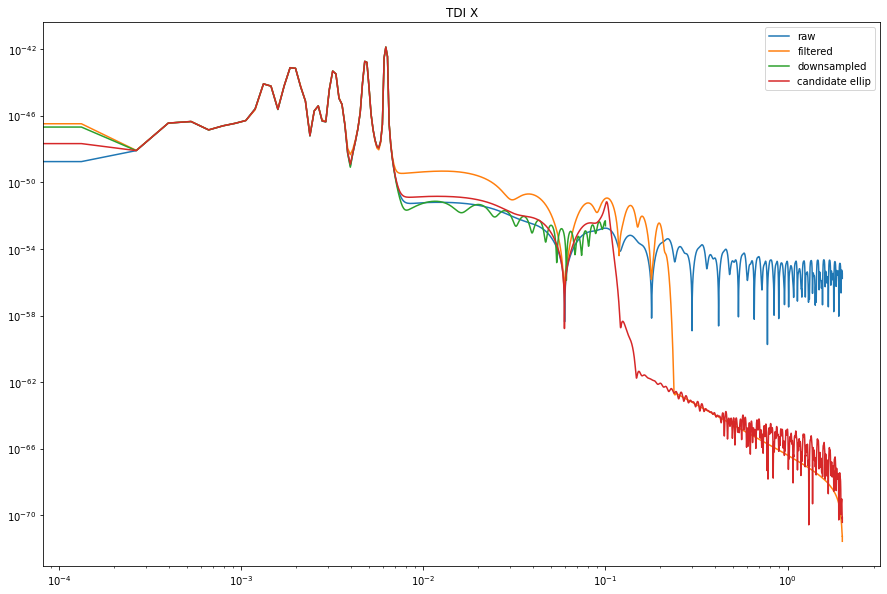

In [21]:
sos = signal.ellip(N, Ap, As, wc, 'lowpass', output='sos')
X2_data_candidate = signal.sosfilt(sos, X2_data_laser)#X2_data_shifted)
f3, psd_3 = scipy.signal.welch(X2_data_candidate, fs=1.0/dt_i, window='hanning', nperseg=256*256)

attenuation = 240
freq1 = 0.05
freq2 = 0.1
df = 1/dt_i
numtaps, beta = scipy.signal.kaiserord(attenuation, (freq2 - freq1) / (df/2.))
filter_coeff = scipy.signal.firwin(numtaps, 0.1, window=('kaiser', beta))
#X2_data_candidate = scipy.signal.lfilter(filter_coeff, 1, X2_data_shifted)
#f4, psd_4 = scipy.signal.welch(X2_data_candidate, fs=1.0/dt_i, window='hanning', nperseg=256*256)

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.loglog(f0, psd_0, label="raw")
plt.loglog(f1, psd_1, label="filtered")
plt.loglog(f2, psd_2, label='downsampled')
plt.loglog(f3, psd_3, label='candidate ellip')
#plt.loglog(f4, psd_4, label='candidate kaiser')
plt.legend()


36


(5000.0, 7000.0, -2e-25, 2e-25)

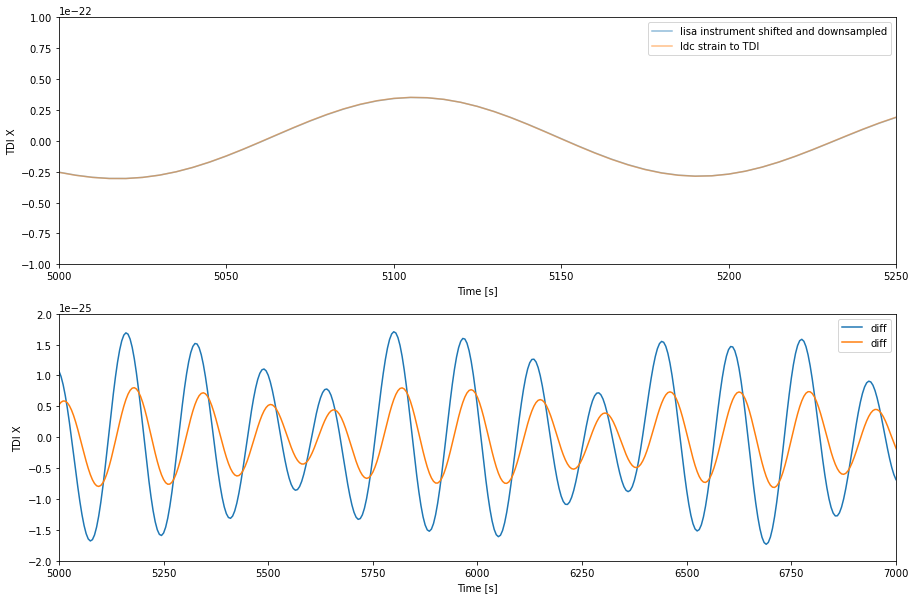

In [22]:
import scipy.interpolate

tdifilter_deltat = 161.75 # sec
tdifilter_deltat = 9. #161.75 # sec
i1 = int(tdifilter_deltat/dt_i)
print(i1)
X2_data_filtered_shifted = scipy.interpolate.InterpolatedUnivariateSpline(i2.t-(9.8+4.5), X2_data_candidate, k=5)(tvec)
X2_data_filtered_shifted2 = scipy.interpolate.InterpolatedUnivariateSpline(i2.t-(9.9+4.5), X2_data_candidate, k=5)(tvec)
#X2_data_filtered_shifted = np.zeros((len(X2_data_filtered)))
#X2_data_filtered_shifted[:-i1] = X2_data_candidate[i1:]
#X2_data_filtered_shifted = X2_data_filtered_shifted[::r_dt]

plt.figure(figsize=(15,10))
plt.title("TDI X")
plt.subplot(211)
plt.plot(tvec, X2_data_filtered_shifted, label="lisa instrument shifted and downsampled", alpha=0.5)
plt.plot(tvec, tdi_x, label="ldc strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([5000, 5250, -1e-22, 1e-22])
plt.subplot(212)
plt.plot(tvec, X2_data_filtered_shifted-tdi_x, label="diff", alpha=1)
plt.plot(tvec, X2_data_filtered_shifted2-tdi_x, label="diff", alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()
plt.axis([5000, 7000, -2e-25, 2e-25])
